

 # 基于增量元学习训练傅里叶神经算子(FNO)

 本示例展示了增量元学习FNO算法在小型Darcy-Flow（达西流）数据集上的使用。



 本教程演示了神经算子的增量元学习方法，该方法允许模型在训练过程中**逐步提升复杂度**，带来以下优势：



 - 更好的收敛特性

 - 更稳定的训练动态

 - 更强的泛化能力

 - 降低训练初期的计算开销



 增量训练的核心思路：从少量傅里叶模式（Fourier Modes）开始训练，随着训练推进逐步增加模型容量。



In [1]:
# 导入核心依赖库
import torch  # PyTorch核心库，用于张量计算和深度学习
import matplotlib.pyplot as plt  # 绘图库，用于可视化结果
import sys  # 系统库，用于刷新输出
from neuralop.models import FNO  # 从NeuralOP库导入傅里叶神经算子模型
from neuralop.data.datasets import load_darcy_flow_small  # 加载小型Darcy-Flow数据集
from neuralop.utils import count_model_params  # 统计模型参数数量的工具函数
from neuralop.training import AdamW  # 导入带权重衰减的Adam优化器
from neuralop.training.incremental import IncrementalFNOTrainer  # 增量FNO训练器
from neuralop.data.transforms.data_processors import IncrementalDataProcessor  # 增量数据处理器
from neuralop import LpLoss, H1Loss  # 导入损失函数：Lp损失（常用L2）和H1损失


尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages
尝试打开的路径是: c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages






 ## 加载Darcy-Flow数据集

 加载适用于增量训练的多分辨率Darcy-Flow数据集（达西流是渗流力学中的经典问题，用于模拟流体在多孔介质中的流动）。





In [2]:
# 加载小型Darcy-Flow数据集
# 参数说明：
# n_train: 训练集样本数量
# batch_size: 训练批次大小
# test_resolutions: 测试集的分辨率列表（16x16和32x32）
# n_tests: 对应不同分辨率测试集的样本数（16分辨率100个，32分辨率50个）
# test_batch_sizes: 对应不同分辨率测试集的批次大小
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=100,
    batch_size=16,
    test_resolutions=[16, 32],
    n_tests=[100, 50],
    test_batch_sizes=[32, 32],
)

# 设置计算设备：优先使用GPU（CUDA），无GPU则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 




 ## 配置增量训练的初始傅里叶模式

 配置增量FNO模型的初始傅里叶模式数（傅里叶模式数决定了FNO捕捉高频信息的能力，数量越多模型容量越大）。 模型会在训练过程中逐步增加模式数，提升容量。 这里选择基于梯度方差的增量模式更新算法。





In [3]:
# 是否启用增量训练
incremental = True
if incremental:
    starting_modes = (2, 2)  # 增量训练：初始仅使用2x2个傅里叶模式（模型容量小）
else:
    starting_modes = (8, 8)  # 非增量训练：直接使用标准8x8个傅里叶模式






 ## 创建增量FNO模型

 构建FNO模型，设置训练过程中可达到的最大傅里叶模式数。

 模型从少量模式开始，训练中逐步增长到最大模式数。





In [4]:
# 初始化FNO模型
model = FNO(
    max_n_modes=(8, 8),  # 训练过程中模型可达到的最大傅里叶模式数
    n_modes=starting_modes,  # 模型初始的傅里叶模式数
    hidden_channels=32,  # 隐藏层通道数（控制模型宽度）
    in_channels=1,  # 输入通道数（Darcy-Flow输入为渗透率场，单通道）
    out_channels=1,  # 输出通道数（Darcy-Flow输出为压力场，单通道）
)
# 将模型移至指定计算设备（GPU/CPU）
model = model.to(device)
# 统计模型参数数量（用于评估模型复杂度）
n_params = count_model_params(model)






 ## 设置优化器和学习率调度器

 使用AdamW优化器（带权重衰减的Adam），权重衰减用于正则化，防止过拟合。 学习率调度器采用余弦退火策略，随训练轮数衰减学习率。





In [5]:
# 初始化AdamW优化器
# 参数说明：
# lr: 初始学习率
# weight_decay: 权重衰减系数（L2正则化）
optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
# 学习率调度器：余弦退火
# T_max: 学习率完成一个余弦周期的轮数（这里设为30轮）
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)




 ## 配置增量数据处理器

 如果需要使用"增量分辨率"训练策略，需初始化IncrementalDataProcessor。 将其传入训练器后，训练器会自动在训练过程中提升输入数据的分辨率。



 增量分辨率核心参数说明：



 - incremental_resolution: 布尔值，是否启用增量分辨率

 - incremental_res_gap: 分辨率更新的间隔参数

 - subsampling_rates: 分辨率缩放因子列表（2表示降采样为1/2分辨率，1表示原始分辨率）

 - dataset_indices: 用于正则化输入分辨率的数据集索引列表

 - dataset_resolution: 输入数据的基础分辨率

 - epoch_gap: 分辨率提升的轮数间隔（每训练多少轮提升一次分辨率）

 - verbose: 是否打印分辨率/模式数的更新信息





In [6]:
# 初始化增量数据处理器
data_transform = IncrementalDataProcessor(
    in_normalizer=None,  # 输入数据归一化器（这里未使用）
    out_normalizer=None,  # 输出数据归一化器（这里未使用）
    device=device,  # 数据处理的计算设备
    subsampling_rates=[2, 1],  # 分辨率缩放因子（先2倍降采样，再恢复原始分辨率）
    dataset_resolution=16,  # 数据集的基础分辨率（16x16）
    dataset_indices=[2, 3],  # 用于分辨率正则化的数据集索引
    epoch_gap=10,  # 每训练10轮检查是否提升分辨率
    verbose=True,  # 打印分辨率更新的日志信息
)

# 将数据处理器移至指定计算设备
data_transform = data_transform.to(device)


Original Incre Res: change index to 0
Original Incre Res: change sub to 2
Original Incre Res: change res to 8






 ## 设置损失函数

 训练过程使用H1损失（包含函数值和梯度的L2损失，更适合偏微分方程求解）， 评估过程同时使用H1损失和L2损失（LpLoss，p=2），全面评估模型性能。





In [7]:
# 初始化L2损失（LpLoss，d=2表示2维数据，p=2表示L2范数）
l2loss = LpLoss(d=2, p=2)
# 初始化H1损失（2维数据的H1范数损失，=L2损失 + 梯度的L2损失）
h1loss = H1Loss(d=2)
# 训练使用的损失函数
train_loss = h1loss
# 评估使用的损失函数字典（同时监控H1和L2损失）
eval_losses = {"h1": h1loss, "l2": l2loss}




 ## 打印训练配置信息

 打印模型参数数量、优化器、调度器、损失函数等关键配置， 验证增量训练的设置是否符合预期。





In [8]:
# 打印模型参数数量
print("\n### 模型参数数量 ###\n", n_params)
# 打印优化器配置
print("\n### 优化器配置 ###\n", optimizer)
# 打印学习率调度器配置
print("\n### 学习率调度器 ###\n", scheduler)
# 打印损失函数配置
print("\n### 损失函数 ###")
print("\n### 增量分辨率 + 梯度驱动增量学习 ###")
print(f"\n * 训练损失: {train_loss}")
print(f"\n * 评估损失: {eval_losses}")
# 强制刷新标准输出（确保日志即时打印）
sys.stdout.flush()



### 模型参数数量 ###
 537441

### 优化器配置 ###
 AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 0.008
    lr: 0.008
    weight_decay: 0.0001
)

### 学习率调度器 ###

### 损失函数 ###

### 增量分辨率 + 梯度驱动增量学习 ###

 * 训练损失: <neuralop.losses.data_losses.H1Loss object at 0x000001A34B22B950>

 * 评估损失: {'h1': <neuralop.losses.data_losses.H1Loss object at 0x000001A34B22B950>, 'l2': <neuralop.losses.data_losses.LpLoss object at 0x000001A34DA4E570>}




 ## 初始化增量FNO训练器

 配置IncrementalFNOTrainer，集成所有增量学习的核心逻辑。 本示例仅启用"基于梯度的模式增量更新"，未启用分辨率增量和损失间隙增量。 增量训练核心参数说明：



 - incremental_grad: 是否启用基于梯度方差的增量算法（核心开关）

 - incremental_grad_eps: 梯度方差阈值（超过阈值则增加模式数）

 - incremental_buffer: 计算梯度方差的缓冲模式数

 - incremental_max_iter: 初始迭代次数

 - incremental_grad_max_iter: 梯度累积的最大迭代次数

 - incremental_loss_gap: 是否启用基于损失间隙的增量算法

 - incremental_loss_eps: 损失间隙阈值（低于阈值则增加模式数）





In [9]:
# 初始化增量FNO训练器
trainer = IncrementalFNOTrainer(
    model=model,  # 待训练的FNO模型
    n_epochs=20,  # 总训练轮数
    data_processor=data_transform,  # 增量数据处理器
    device=device,  # 训练使用的计算设备
    verbose=True,  # 打印训练过程日志
    incremental_loss_gap=False,  # 关闭基于损失间隙的增量算法
    incremental_grad=True,  # 启用基于梯度方差的模式增量更新
    incremental_grad_eps=0.9999,  # 梯度方差阈值（控制模式增长的灵敏度）
    incremental_loss_eps=0.001,  # 损失间隙阈值（本示例未启用，仅占位）
    incremental_buffer=5,  # 计算梯度方差的缓冲模式数
    incremental_max_iter=1,  # 初始迭代次数
    incremental_grad_max_iter=2,  # 梯度累积的最大迭代次数
)






 ## 训练增量FNO模型

 启动增量元学习训练流程，训练器会自动执行以下逻辑：

 1. 从少量傅里叶模式开始训练

 2. 基于梯度方差逐步增加模型的傅里叶模式数（提升容量）

 3. 实时监控增量学习的进度

 4. 在训练过程中定期评估测试集性能





In [10]:
# 启动模型训练
trainer.train(
    train_loader,  # 训练集数据加载器
    test_loaders,  # 测试集数据加载器（多分辨率）
    optimizer,  # 优化器
    scheduler,  # 学习率调度器
    regularizer=False,  # 是否启用正则化（本示例未启用）
    training_loss=train_loss,  # 训练损失函数
    eval_losses=eval_losses,  # 评估损失函数字典
)


Training on 100 samples
Testing on [50, 50] samples         on resolutions [16, 32].


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1786: UserWarning: FNO.forward() received unexpected keyword arguments: ['y']. These arguments will be ignored.
  return forward_call(*args, **kwargs)
c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:536: UserWarning: H1Loss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


Raw outputs of shape torch.Size([16, 1, 8, 8])
[0] time=3.26, avg_loss=0.9238, train_err=13.1967


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\trainer.py:581: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  val_loss = loss(out, **sample)


Eval: 16_h1=0.8801, 16_l2=0.6461, 32_h1=0.9256, 32_l2=0.6512
[1] time=3.08, avg_loss=0.7652, train_err=10.9308
Eval: 16_h1=0.7738, 16_l2=0.6409, 32_h1=0.9237, 32_l2=0.6429
[2] time=3.12, avg_loss=0.6782, train_err=9.6888


c:\Users\MR\AppData\Local\Programs\Python\Python312\Lib\site-packages\neuralop\training\incremental.py:244: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  torch.Tensor(strength_vector),


Eval: 16_h1=0.9554, 16_l2=0.7077, 32_h1=1.2185, 32_l2=0.7532
[3] time=3.07, avg_loss=0.6712, train_err=9.5887
Eval: 16_h1=0.7213, 16_l2=0.3798, 32_h1=0.8858, 32_l2=0.3962
[4] time=3.14, avg_loss=0.5859, train_err=8.3698
Eval: 16_h1=0.8086, 16_l2=0.4520, 32_h1=1.0776, 32_l2=0.4918
[5] time=3.14, avg_loss=0.5718, train_err=8.1687
Eval: 16_h1=0.8238, 16_l2=0.5534, 32_h1=1.0845, 32_l2=0.5660
[6] time=3.21, avg_loss=0.6015, train_err=8.5936
Eval: 16_h1=0.8114, 16_l2=0.4242, 32_h1=1.1409, 32_l2=0.4706
[7] time=3.17, avg_loss=0.5215, train_err=7.4496
Eval: 16_h1=0.6314, 16_l2=0.3419, 32_h1=0.8271, 32_l2=0.3653
[8] time=3.11, avg_loss=0.4595, train_err=6.5646
Eval: 16_h1=0.7913, 16_l2=0.4828, 32_h1=0.9547, 32_l2=0.5093
[9] time=3.13, avg_loss=0.5623, train_err=8.0323
Eval: 16_h1=0.6615, 16_l2=0.3949, 32_h1=0.9559, 32_l2=0.4295
Incre Res Update: change index to 1
Incre Res Update: change sub to 1
Incre Res Update: change res to 16
[10] time=3.29, avg_loss=0.5844, train_err=8.3488
Eval: 16_h1=0.

{'train_err': 4.868867022650583,
 'avg_loss': 0.3408206915855408,
 'avg_lasso_loss': None,
 'epoch_train_time': 3.2414279999975406,
 '16_h1': tensor(0.3390),
 '16_l2': tensor(0.2102),
 '32_h1': tensor(0.4496),
 '32_l2': tensor(0.2181)}





 ## 可视化增量FNO的预测结果

 训练完成后，可视化模型的预测结果，对比输入、真实值和预测值。 注意：本示例为轻量化演示，仅使用小分辨率、少样本、少训练轮数， 实际应用中需使用更大分辨率、更多样本，并在GPU上训练更多轮数。


 轻量化设计的目的：

 i) 内存占用仅几MB

 ii) 可在CPU上快速完成训练



 实际场景中，神经算子通常在单/多GPU上训练。





C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 28183 (\N{CJK UNIFIED IDEOGRAPH-6E17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 36879 (\N{CJK UNIFIED IDEOGRAPH-900F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MR\AppData\Local\Temp\ipykernel_14408\2890580348.py:50: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEO

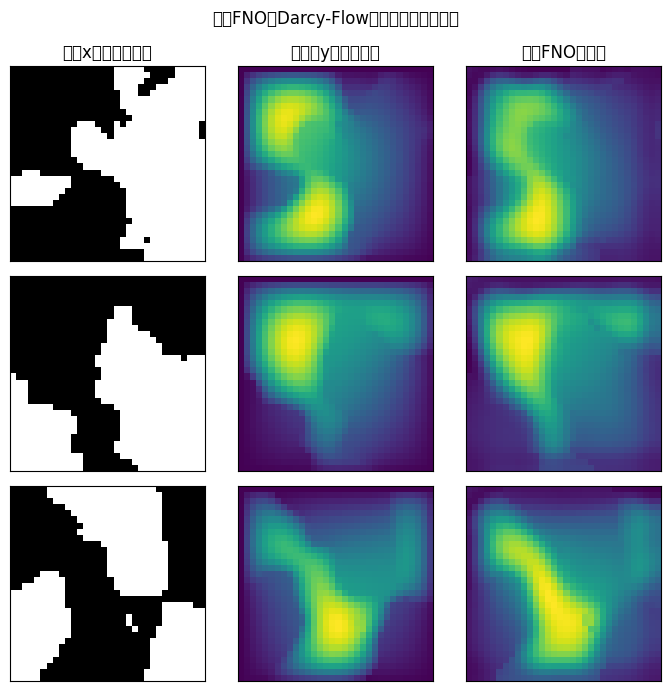

In [11]:
# 获取32x32分辨率的测试集样本
test_samples = test_loaders[32].dataset

# 创建绘图画布，设置尺寸为7x7英寸
fig = plt.figure(figsize=(7, 7))
# 可视化前3个测试样本
for index in range(3):
    # 获取第index个测试样本
    data = test_samples[index]
    # 输入特征x（渗透率场），移至计算设备
    x = data["x"].to(device)
    # 真实标签y（压力场），移至计算设备
    y = data["y"].to(device)
    # 模型预测：添加batch维度（模型输入需为[batch, channel, H, W]）
    out = model(x.unsqueeze(0))

    # 绘制输入x（渗透率场）
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    # 转换为CPU张量，去除多余维度，转为numpy数组（便于绘图）
    x = x.cpu().squeeze().detach().numpy()
    y = y.cpu().squeeze().detach().numpy()
    # 灰度图绘制渗透率场
    ax.imshow(x, cmap="gray")
    # 仅在第一个样本的子图添加标题
    if index == 0:
        ax.set_title("输入x（渗透率场）")
    # 隐藏坐标轴刻度（美化图表）
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制真实值y（压力场）
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title("真实值y（压力场）")
    plt.xticks([], [])
    plt.yticks([], [])

    # 绘制模型预测值
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    ax.imshow(out.cpu().squeeze().detach().numpy())
    if index == 0:
        ax.set_title("增量FNO预测值")
    plt.xticks([], [])
    plt.yticks([], [])

# 设置总标题，调整位置（y=0.98避免被裁剪）
fig.suptitle("增量FNO在Darcy-Flow数据集上的预测结果", y=0.98)
# 自动调整子图间距
plt.tight_layout()
# 显示图表
fig.show()